In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
from torch.nn import Module
from torchviz import make_dot

from tqdm import tqdm

In [2]:
data_dir = "D:\\Documents\\CMU_SUBJECTS\\Deep Learning\\Generative_Modelling\\SimpleGAN\\data\\pokemon"
pokemon = torchvision.datasets.ImageFolder(data_dir)

Observing input distribution


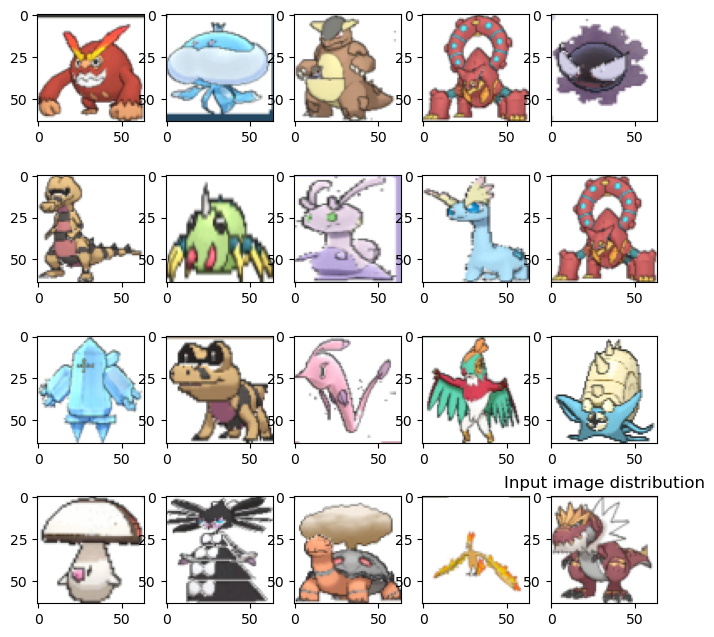

In [3]:
batch_size = 256
transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer

# Dataloader class 
train_loader = DataLoader(dataset = pokemon, shuffle= True, batch_size= batch_size, num_workers = 4)

# Some pokemons 
#plt.set_figsize((4,4))
for i, (X, y) in enumerate(train_loader):
    img = X[:20, ].permute(0,2,3,1)/2 + 0.5
    break

print("Observing input distribution") 
warnings.filterwarnings('ignore')

fig=plt.figure(figsize=(8, 8))
rows, cols = 4, 5

for j in range(0, cols*rows):
  fig.add_subplot(rows, cols, j+1)
  plt.imshow(img[j])
plt.title("Input image distribution")
plt.show()



In [4]:
"""
Discriminator 
Conv2D with three input channels 
kernel 4 
stride 2 
"""
class DiscriminatorBlock(Module):
    def __init__(self, output_channel, input_channel = 3, kernel_size = 4, stride = 2, alpha = 0.2, padding = 1):
        super(DiscriminatorBlock, self).__init__()
        
        self.disc = nn.Sequential(nn.Conv2d(in_channels = input_channel, out_channels = output_channel, kernel_size=kernel_size, stride=stride, padding = padding, bias = False), 
                    nn.BatchNorm2d(output_channel), nn.LeakyReLU(alpha, inplace= True))
    
    def forward(self, x):
        return self.disc(x)
n= 64
discriminator = nn.Sequential(DiscriminatorBlock(output_channel= n), DiscriminatorBlock(input_channel = n, output_channel= n*2),DiscriminatorBlock(input_channel = n*2, output_channel= n*4)
                , DiscriminatorBlock(input_channel = n*4, output_channel= n*8),nn.Conv2d(in_channels = n*8 ,out_channels = 1, kernel_size=4, bias = False))


In [5]:
"""
Generator
Conv2D with three input channels 
kernel 4 
stride 2 
"""
class GeneratorBlock(Module):
    def __init__(self, output_channel, input_channel = 3, kernel_size = 4, stride = 2, padding = 1):
        super(GeneratorBlock, self).__init__()
        
        self.disc = nn.Sequential(nn.ConvTranspose2d(in_channels = input_channel, out_channels = output_channel, kernel_size=kernel_size, stride=stride, padding = padding, bias = False), 
                    nn.BatchNorm2d(output_channel), nn.ReLU())
    
    def forward(self, x):
        return self.disc(x)
n= 64
generator = nn.Sequential(GeneratorBlock(input_channel=100, output_channel=n*8,stride =1, padding=0), 
                        GeneratorBlock(input_channel=n*8, output_channel=n*4),GeneratorBlock(input_channel = n*4, output_channel= n*2)
                , GeneratorBlock(input_channel = n*2, output_channel= n),nn.ConvTranspose2d(in_channels=n, out_channels=3,
                    kernel_size=4, stride=2, padding=1, bias=False))


In [6]:
# for i, (X,y) in enumerate(train_loader):
#     yhat = discriminator(X)
#     break
# make_dot(yhat, params=dict(list(discriminator.named_parameters()))).render("disc", format="png")

### Setting up the min-max training routine 

In [7]:
def train_disc(disc, gen, optimizer, X, Z, loss):
    batch_size = X.shape[0]
    # Labels 
    ones = torch.ones((batch_size, ), device = X.device) 
    zeros = torch.zeros((batch_size, ), device = X.device)
    
    real_Y = disc(X)
    fake_X = gen(Z)
    fake_Y = disc(fake_X.detach())
    
    loss = (loss(real_Y, ones.reshape(real_Y.shape))+ loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss.backward()

    optimizer.step()

    return loss 


In [8]:
def train_gen(disc, gen, optimizer, Z, loss):
    batch_size = Z.shape[0]
    # Labels 
    ones = torch.ones((batch_size, ), device = Z.device) 
    optimizer.zero_grad()

    fake_X = gen(Z)
    fake_Y = disc(fake_X)
    
    loss = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss.backward()
    optimizer.step()

    return loss 

In [9]:
"""
Training 
Loss function : BinaryCrossEntropy
"""
device = "cuda"
loss = nn.BCEWithLogitsLoss(reduce="sum")
batch_size
epochs = 50 
latent_dim = 100
# Initialize the neural net weights 

for w in discriminator.parameters():
    nn.init.normal_(w, 0.0, 0.02)
for w in generator.parameters():
    nn.init.normal_(w,0.0, 0.02)

# Initialize optimizer 
discriminator, generator = discriminator.to(device=device), generator.to(device=device)
print("Models Loaded to GPU")
trainerDisc = torch.optim.Adam(discriminator.parameters(),lr= 0.005 ,betas=[0.5, 0.999])
trainerGen = torch.optim.Adam(generator.parameters(),lr= 0.005 ,betas=[0.5, 0.999])
loss_lstgen, loss_lstdes = [], []
print("Training ....")
for epoch in range(epochs+1):
    loss_disc, loss_gen = 0, 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    for i, (X,y) in enumerate(train_loader):
        batch_size = X.shape[0]
        # 1x100 sized latent input 
        Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
        X, Z = X.to(device), Z.to(device)
        loss_disc += train_disc(discriminator,generator, trainerDisc, X, Z, loss)
        loss_gen += train_gen(discriminator, generator, trainerGen, Z, loss)
        batch_bar.set_postfix(
            lossD="{:.04f}".format(loss_disc/(i+1)),
            lossG="{:.04f}".format(loss_gen/(i+1)))
        batch_bar.update()
    print("Epoch : {}  | D loss : {} | G loss : {}|".format(epoch, loss_disc/batch_size, loss_gen/batch_size))
    loss_lstgen.append(loss_gen.to('cpu')/batch_size)
    loss_lstdes.append(loss_disc.to('cpu')/batch_size)

    # Save the model
    torch.save({'generator_state_dict':generator.state_dict(),
                    'generator_optim_state_dict':trainerGen.state_dict(), 'disc_state_dict' : discriminator.state_dict()
                    , 'disc_optim_state_dict':trainerDisc.state_dict()}, 
                    'D:\\Documents\\CMU_SUBJECTS\\Deep Learning\\Generative_Modelling\\SimpleGAN\\PokeGAN\\ckpt\\model_{}.pth'.format(epoch))

Models Loaded to GPU
Training ....


Train: 100%|██████████| 159/159 [01:38<00:00,  2.04it/s, lossD=4.5843, lossG=0.5029]

Epoch : 0  | D loss : 4.891925811767578 | G loss : 0.5366249084472656|


Train: 100%|██████████| 159/159 [01:35<00:00,  2.07it/s, lossD=34.1838, lossG=6.7094]

Epoch : 1  | D loss : 36.47798538208008 | G loss : 7.159697532653809|


Train: 100%|██████████| 159/159 [01:35<00:00,  2.05it/s, lossD=79.8760, lossG=13.7879]

Epoch : 2  | D loss : 85.23680114746094 | G loss : 14.713212013244629|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.07it/s, lossD=118.1004, lossG=21.3453]

Epoch : 3  | D loss : 126.02658081054688 | G loss : 22.77789306640625|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.08it/s, lossD=166.7332, lossG=19.4722]

Epoch : 4  | D loss : 177.92340087890625 | G loss : 20.779056549072266|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.06it/s, lossD=202.9971, lossG=48.4270]

Epoch : 5  | D loss : 216.62103271484375 | G loss : 51.677154541015625|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.07it/s, lossD=252.7724, lossG=48.7744]

Epoch : 6  | D loss : 269.73699951171875 | G loss : 52.04782485961914|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.07it/s, lossD=298.0622, lossG=44.6380]

Epoch : 7  | D loss : 318.06640625 | G loss : 47.63386917114258|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.07it/s, lossD=325.4083, lossG=51.5272]

Epoch : 8  | D loss : 347.2478332519531 | G loss : 54.9853515625|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.08it/s, lossD=358.4458, lossG=52.5152]

Epoch : 9  | D loss : 382.5025329589844 | G loss : 56.03974533081055|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.07it/s, lossD=394.0083, lossG=53.2617]

Epoch : 10  | D loss : 420.4518737792969 | G loss : 56.836265563964844|


Train: 100%|██████████| 159/159 [01:34<00:00,  2.08it/s, lossD=519.9449, lossG=79.0332] 

Epoch : 11  | D loss : 554.840576171875 | G loss : 84.3375015258789|


Train: 100%|██████████| 159/159 [01:35<00:00,  2.08it/s, lossD=455.5497, lossG=95.7938] 

Epoch : 12  | D loss : 486.12347412109375 | G loss : 102.22286987304688|


Train: 100%|██████████| 159/159 [01:35<00:00,  2.07it/s, lossD=536.4315, lossG=93.0968]

Epoch : 13  | D loss : 572.43359375 | G loss : 99.34490966796875|


Train: 100%|██████████| 159/159 [01:36<00:00,  1.97it/s, lossD=633.9412, lossG=79.3316] 

Epoch : 14  | D loss : 676.4876098632812 | G loss : 84.6559066772461|


Train: 100%|██████████| 159/159 [01:40<00:00,  1.96it/s, lossD=562.1651, lossG=121.9509]

Epoch : 15  | D loss : 599.8943481445312 | G loss : 130.1355743408203|


Train: 100%|██████████| 159/159 [01:38<00:00,  2.11it/s, lossD=680.9744, lossG=50.6794] 

Epoch : 16  | D loss : 726.6773681640625 | G loss : 54.080753326416016|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.03it/s, lossD=581.6662, lossG=118.2974]

Epoch : 17  | D loss : 620.7042236328125 | G loss : 126.23680114746094|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.03it/s, lossD=775.2307, lossG=71.5211] 

Epoch : 18  | D loss : 827.2595825195312 | G loss : 76.32112884521484|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.04it/s, lossD=613.9334, lossG=151.9479]

Epoch : 19  | D loss : 655.1370239257812 | G loss : 162.1457061767578|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.06it/s, lossD=808.3581, lossG=101.2396]

Epoch : 20  | D loss : 862.6103515625 | G loss : 108.03425598144531|


Train: 100%|██████████| 159/159 [01:36<00:00,  2.05it/s, lossD=884.6060, lossG=114.5394]

Epoch : 21  | D loss : 943.9755859375 | G loss : 122.22663116455078|


Train: 100%|██████████| 159/159 [08:16<00:00,  2.02s/it, lossD=767.8684, lossG=237.9095]

Epoch : 22  | D loss : 819.4032592773438 | G loss : 253.87660217285156|


Train: 100%|██████████| 159/159 [01:41<00:00,  2.04it/s, lossD=820.9836, lossG=117.2735]

Epoch : 23  | D loss : 876.0831909179688 | G loss : 125.14425659179688|


Train: 100%|██████████| 159/159 [01:36<00:00,  2.04it/s, lossD=985.5391, lossG=110.7805]

Epoch : 24  | D loss : 1051.6827392578125 | G loss : 118.21539306640625|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.01it/s, lossD=754.6472, lossG=154.5870]

Epoch : 25  | D loss : 805.2946166992188 | G loss : 164.96194458007812|


Train: 100%|██████████| 159/159 [01:37<00:00,  2.04it/s, lossD=782.3747, lossG=133.7335]

Epoch : 26  | D loss : 834.883056640625 | G loss : 142.7089080810547|


Train:  54%|█████▍    | 86/159 [00:54<00:41,  1.78it/s, lossD=942.8899, lossG=171.9431] 

KeyboardInterrupt: 